In [1]:
### Notebook creado para extraer los embebidos de las imágenes confocales

## Librerías: 
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import glob

import random 

2023-08-02 17:58:58.721336: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 17:58:58.772359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

In [2]:
### Cargar imágenes tal cual como se cargaron para el entrenamiento:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
### Rutas
classes = ['CuNi1','CuNi2','CuNi3']
route_img = []
labels = []
cls = []


for clss in classes:
    cnt = 0
    route = ('../../Datasets/Confocales_procesadas/recortadas1/'+clss+"/*.jpg")
    path = glob.glob(route) 
    for img in path:
        #print(img)
        route_img.append(img)    
        #labels.append(img)
        cls.append(clss)
        cnt = cnt +1;


images_df = pd.DataFrame()
images_df['routes'] = route_img
images_df['label'] = cls
#images_df['classes'] = cls

## Conversión de etiquetas
char_to_num = {}
num_to_char = {}

i = 0
for name in classes:
  num_to_char[i] = name
  char_to_num[name] = str(i)
  i += 1

images_df['label'].replace(char_to_num,inplace=True)

In [4]:
## Establecer el porcentaje de separación
thold = int(np.ceil(0.8 * len(images_df)/3))

## Separar por clases para entrenamiento
train_cu1 = images_df[images_df.label == '0'][0:thold]
train_cu2 = images_df[images_df.label == '1'][0:thold]
train_cu3 = images_df[images_df.label == '2'][0:thold]

## tomar las demás imágenes para test
test_cu1 = images_df[images_df.label == '0'][thold:]
test_cu2 = images_df[images_df.label == '1'][thold:]
test_cu3 = images_df[images_df.label == '2'][thold:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

In [5]:
## Crear objetos transformadores
## Para entrenamiento
img_generator_training = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15
)

# Para testing
img_generator_test = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True    
)

In [6]:
## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['CuNi1','CuNi2','CuNi3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

## Para validación
valid_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['CuNi1','CuNi2','CuNi3'],
    subset="validation",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    color_mode ="grayscale",
    target_size=(128,128))

## Para testeo
test_generator= img_generator_test.flow_from_dataframe(
    dataframe=test_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['CuNi1','CuNi2','CuNi3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    color_mode ="grayscale",
    target_size=(128,128))

Found 408 validated image filenames belonging to 3 classes.
Found 72 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


In [7]:
x_train_expanded = []
y_train_expanded = []

x_test = []
y_test = []

batches = 50
cnt = 0;

for i in range(batches):
    
    x,y = train_generator.next()

    x_train_expanded.extend(x)
    y_train_expanded.extend(y)

for j in range(int(np.ceil(batches*0.2))):
    
    x,y = test_generator.next()

    x_test.extend(x)
    y_test.extend(y)

print(np.shape(x_train_expanded),np.shape(y_train_expanded))
print(np.shape(x_test), np.shape(y_test))

(2920, 128, 128, 1) (2920,)
(600, 128, 128, 1) (600,)


(128, 128, 1)
0.0 1.0


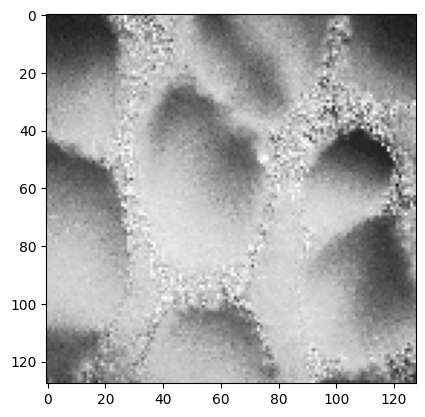

In [8]:
plt.imshow(x_train_expanded[0],cmap='gray')
print(np.shape(x_train_expanded[0]))
print(np.min(x_train_expanded[0]),np.max(x_train_expanded[0]))
plt.show()

In [9]:
x_train_expanded = np.array(x_train_expanded)
x_test = np.array(x_test)

x_train_expanded = x_train_expanded.astype('float32')
x_test= x_test.astype('float32')
 
#y_test = tf.keras.utils.to_categorical(y_test)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
#x_test /= 255

print('x_train shape:', x_train_expanded.shape)
print('Number of images in x_train', x_train_expanded.shape[0], "y_train:", np.shape(y_train_expanded))
print('Number of images in x_test', x_test.shape, "y_test: ", np.shape(y_test))

x_train shape: (2920, 128, 128, 1)
Number of images in x_train 2920 y_train: (2920,)
Number of images in x_test (600, 128, 128, 1) y_test:  (600,)


In [10]:
### Cargar modelo
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
encoder = keras.models.load_model('models/VAE_1_encoder_128.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('models/VAE_1_decoder_128.h5', custom_objects={'Sampling':Sampling})

2023-07-31 21:47:53.563134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22784 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [13]:
### Embebidos training
encoder_embds  = encoder.predict(x_train_expanded)
print('Shape_embs: ',np.shape(encoder_embds))

2023-07-31 21:48:01.003299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


92/92 [==============================] - 5s 22ms/step
Shape_embs:  (3, 2920, 128)


In [14]:
labels_train = pd.DataFrame(y_train_expanded).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_train.shape

(2920, 1)

In [22]:
## Dataframe
embs_training = pd.DataFrame()
embs_training['embedding_mean'] =list(encoder_embds[0])
embs_training['embedding_logvar'] = list(encoder_embds[1])
embs_training['embedding_z'] = list(encoder_embds[2])

In [56]:
### Diferencias con kullback-leibler
errors_training = []
for i in range(len(embs_training)):
    z_log_var = embs_training.iloc[i].embedding_logvar
    z_mean = embs_training.iloc[i].embedding_mean	
    error = 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    errors_training.append(np.mean(error.numpy()))
    
np.shape(errors_training)

(2920,)

In [57]:
embs_training['KL_loss'] = errors_training
embs_training['label'] = labels_train
embs_training

,embedding_mean,embedding_logvar,embedding_z,KL_loss,label
0,"[-0.48370373, -0.44313332, -0.43165365, -1.523...","[-2.147362, -2.4574099, -2.2709641, -2.3747203...","[-0.60850203, -0.7727723, -0.41284814, -1.8507...",-1.063745,MF1
1,"[-1.0387968, 0.27876616, -0.8933149, 0.5040709...","[-2.4984908, -2.6425052, -2.3935938, -2.318457...","[-1.2391117, 0.5804928, -1.2606264, 0.8411063,...",-1.274560,MF2
2,"[-1.4117372, 1.7300321, -1.6898838, -0.7751232...","[-2.6302898, -2.8231316, -2.6396167, -2.592873...","[-1.3637288, 1.3492775, -1.7783668, -1.035386,...",-1.148473,MF3
3,"[-0.33066994, -0.544078, 0.233757, 1.7828923, ...","[-2.1869311, -2.453971, -2.330516, -2.2520123,...","[-0.7035003, -0.63701534, 0.3444556, 2.0992525...",-1.013824,MF1
4,"[0.05739648, 1.9747838, -0.7251491, -0.3393491...","[-2.2424078, -2.5773213, -2.3165581, -2.360484...","[0.3282761, 1.4189906, -0.86411697, -0.2225353...",-1.064858,MF1
...,...,...,...,...,...
2915,"[0.7699096, 1.414756, 1.0586877, -1.0450531, -...","[-2.1759143, -2.5601327, -2.293031, -2.19999, ...","[0.9632327, 1.6844323, 1.4079297, -1.0643599, ...",-1.012856,MF1
2916,"[-0.8249702, -0.25168008, 1.934218, -0.204828,...","[-2.3727813, -2.7867692, -2.718464, -2.3625693...","[-0.68242043, -0.23369338, 1.6419603, -0.02434...",-1.195453,MF2
2917,"[-1.6391324, -0.8803261, 0.5542589, 1.5081016,...","[-2.5090644, -2.9260182, -2.6827965, -2.818679...","[-1.3458425, -0.9643999, 0.6755364, 1.2738875,...",-1.353036,MF3
2918,"[1.9479651, 1.9160988, 0.23734777, -0.985599, ...","[-2.243434, -2.320411, -2.0918825, -1.8949981,...","[1.7643651, 2.0540345, 0.26090646, -0.7587356,...",-1.098137,MF1


In [1]:
embs_logvar_training = embs_training.embedding_logvar.values.tolist()
embs_mean_trainig = embs_training.embedding_mean.values.tolist()
embs_z_trainig = embs_training.embedding_z.values.tolist()
labels_training = embs_training.label.values.tolist()
errors_training = embs_training.KL_loss.values.tolist()

np.save('results/embebidos_confocales/embs_logvar_training',embs_logvar_training)
np.save('results/embebidos_confocales/embs_mean_training',embs_mean_trainig)
np.save('results/embebidos_confocales/embs_z_training',embs_z_trainig)
np.save('results/embebidos_confocales/label_training',labels_training)
np.save('results/embebidos_confocales/kl_loss_training',errors_training) 

NameError: name 'embs_training' is not defined

In [28]:
### Embebidos test
encoder_embds_Test  = encoder.predict(x_test)
print('Shape_embs: ',np.shape(encoder_embds_Test))

19/19 [==============================] - 1s 52ms/step
Shape_embs:  (3, 600, 128)


In [29]:
labels_test = pd.DataFrame(y_test).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_test.shape

(600, 1)

In [39]:
embs_test = pd.DataFrame()
embs_test['embedding_mean'] =list(encoder_embds_Test[0])
embs_test['embedding_logvar'] = list(encoder_embds_Test[1])
embs_test['embedding_z'] = list(encoder_embds_Test[2])


In [40]:
### Diferencias con kullback-leibler
errors_test = []
for i in range(len(embs_test)):
    z_log_var = embs_test.iloc[i].embedding_logvar
    z_mean = embs_test.iloc[i].embedding_mean	
    error = 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    errors_test.append(np.mean(error.numpy()))
    
np.shape(errors_test)

(600,)

In [41]:
embs_test['KL_loss'] = errors_test
embs_test['label'] = labels_test

embs_test

,embedding_mean,embedding_logvar,embedding_z,KL_loss,label
0,"[-0.47027984, -1.2011987, 0.6600608, 0.0612614...","[-2.2964659, -2.3215568, -2.4162624, -2.739361...","[-0.45845628, -1.2967086, 0.8752455, -0.200644...",-1.168125,MF2
1,"[0.53369427, -0.79866993, 0.07052698, -2.00350...","[-1.9900565, -2.484649, -2.625101, -2.348678, ...","[0.33492613, -0.26651508, -0.02031041, -2.1346...",-1.264808,MF2
2,"[1.6847003, -0.40530923, 0.3609812, -1.6609691...","[-2.5443945, -2.628574, -2.274442, -2.120427, ...","[1.6188793, -0.49287525, 1.0222472, -1.5212545...",-1.102895,MF1
3,"[0.5489903, -0.61190915, -0.55269086, 1.426916...","[-2.511737, -2.6166553, -2.6042767, -2.7921243...","[0.69465625, -1.0468049, -1.0354724, 1.4163119...",-1.252769,MF2
4,"[0.63258135, 0.5749223, 2.0368123, -1.399094, ...","[-2.0581698, -2.466055, -2.3306198, -2.1862702...","[0.57666844, 0.63172716, 2.6946352, -1.4687036...",-1.074732,MF1
...,...,...,...,...,...
595,"[0.47022766, -0.26216882, 1.7868325, -1.188134...","[-2.0245352, -2.5509932, -2.6760468, -2.226676...","[0.9439905, -0.08291967, 1.7688588, -1.489282,...",-1.026593,MF1
596,"[-1.755556, 0.9470208, -0.437136, -0.22237316,...","[-2.302046, -3.4066112, -2.9159424, -2.6143928...","[-1.8692524, 0.7097529, -0.010060996, -0.20807...",-1.258897,MF3
597,"[0.24548075, 1.1279305, -0.8308541, -1.7329123...","[-2.4974065, -2.5967727, -2.2207544, -2.191209...","[0.55378, 0.9371973, -0.39149418, -1.3910182, ...",-1.253409,MF1
598,"[0.44074133, -0.16885145, -0.0059923315, 0.088...","[-2.278202, -3.0245621, -2.7595057, -2.4750562...","[0.36635628, -0.20541817, 0.3964593, 0.1281011...",-1.326813,MF3


In [42]:
embs_logvar_test = embs_test.embedding_logvar.values.tolist()
embs_mean_trainig = embs_test.embedding_mean.values.tolist()
embs_z_trainig = embs_test.embedding_z.values.tolist()
labels_test = embs_test.label.values.tolist()
errors_test = embs_test.KL_loss.values.tolist()

np.save('results/embebidos_confocales/embs_logvar/embs_logvar_test',embs_logvar_test)
np.save('results/embebidos_confocales/embs_mean/embs_mean_test',embs_mean_trainig)
np.save('results/embebidos_confocales/embs_z/embs_z_test',embs_z_trainig)
np.save('results/embebidos_confocales/label/label_test',labels_test)
np.save('results/embebidos_confocales/kl_loss/kl_loss_test',errors_test) 

In [36]:
### exportar dataframes as .csv
ruta_save = 'results/embebidos_confocales/'
embs_test.to_csv(ruta_save+'embs_test.csv', index=False)
embs_training.to_csv(ruta_save+'embs_training.csv', index=False)

In [53]:
### guardar conjuntos de imágenes
np.save('results/embebidos_confocales/img_test',x_test)
np.save('results/embebidos_confocales/img_train_1',x_train_expanded[:1000])
np.save('results/embebidos_confocales/img_train_2',x_train_expanded[1000:2000])
np.save('results/embebidos_confocales/img_train_3',x_train_expanded[2000:])
